### Lecture 5: Computing pitch distributions

In this example, compute and plot pitch distributions for a small set of Turkish makam music samples downloaded using Dunya api. We demonstrate how distributions can be folded and syncronized(in the pitch space) using the tonic information (which is read from the ground truth annotations of the dataset)

In [1]:
import os 
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

from external_utilities.predominantmelodymakam import PredominantMelodyMakam
from external_utilities.pitchdistribution import PitchDistribution

from compmusic import dunya
dunya.set_token('...yourTokenGoesHere...')

%matplotlib inline
CENTS_IN_OCTAVE=1200
REF_PITCH=220

In the next cell we download a small part of the Makam dataset: https://github.com/MTG/otmm_makam_recognition_dataset
which contains both makam and tonic annotations, and compute pitch and pitch distributions for the files (results saved to files in '../data/compMusicDatasets/turkishMakam/' folder)

In [3]:
extractor = PredominantMelodyMakam(filter_pitch=True)
pd_params={'kernel_width': 7.5, 'step_size': 7.5}

dataDir='../data/compMusicDatasets/turkishMakam/'
with open(dataDir+'annotations.json') as json_data:
    collectionFiles = json.load(json_data)
#Setting list of makams for analysis
makams=['Rast','Nihavent','Huseyni','Saba']
numFiles2DownloadPerMakam=3

#Create directories for makams and download one two recording for each
for makam in makams:
    cnt_makam=0
    if not os.path.exists(dataDir+makam):
        os.mkdir(dataDir+makam)
    print('--- Downloading and processing files for makam ',makam,' ---')
    for dbaFile in collectionFiles:
        if(dbaFile['makam']==makam and cnt_makam<numFiles2DownloadPerMakam):
            print(dbaFile['mbid'])
            musicbrainzid=dbaFile['mbid'].split('http://musicbrainz.org/recording/')[-1]
            pitchFile=dataDir+makam+'/'+musicbrainzid+'.pitch'
            histFile=dataDir+makam+'/'+musicbrainzid+'.pitch_hist.json'
            
            mp3FileURI = dunya.makam.download_mp3(musicbrainzid,dataDir+makam)
            print(mp3FileURI)
            #WARNING: you may get "502 Server Error: Bad Gateway for url" if Dunya-server is not functional at this point
            results = extractor.run(mp3FileURI)
            pitch = results['settings']  # collapse the keys in settings
            pitch['pitch'] = results['pitch']
            #writing pitch data to text file, 
            # you can use it together with SonicVisualizer to view in sync with the spectrogram of the mp3 file
            file = open(pitchFile,'w')
            for p_triplet in pitch['pitch']:
                file.write(str(p_triplet[0])+'\t'+str(p_triplet[1])+'\n')
            file.close()

            pitchData = np.loadtxt(pitchFile)
            timeStamps=pitchData[:,0]
            pitchSeriesHz=pitchData[:,1]
            #Computing pitch distribution with reference frequency = REF_PITCH
            pitch_distribution = PitchDistribution.from_hz_pitch(pitchSeriesHz,REF_PITCH, **pd_params)
            pitch_distribution.to_json(histFile)
            #Computing pitch distribution with reference frequency = tonic
            pitch_distribution_tonicRef = PitchDistribution.from_hz_pitch(pitchSeriesHz,dbaFile['tonic'], **pd_params)
            pitch_distribution_tonicRef.to_json(histFile.replace('.pitch_hist.json','.pitch_hist_wrtTonic.json'))
            cnt_makam+=1
print('Files downloaded and processed')

--- Downloading and processing files for makam  Saba  ---
http://musicbrainz.org/recording/0423e513-cb38-4d7a-b229-f96b9ef923e4
../data/compMusicDatasets/turkishMakam/Saba/Halil Uğur Kutlu and Emre Erdal and Ali Sarıgül and Yavuzhan Erdem and Savaş Ş. Barkçin_Gözüm Yokdur.mp3
http://musicbrainz.org/recording/0700046f-3740-4804-9a7c-facdb4c8ccd5
../data/compMusicDatasets/turkishMakam/Saba/[unknown]_Saba Ney Taksim.mp3
http://musicbrainz.org/recording/0b45417b-acb4-4f8a-b180-5ad45be889af
../data/compMusicDatasets/turkishMakam/Saba/Safiye Ayla_Bu Akşam Ay Işığında Buluşalım.mp3
Files downloaded and processed


Next cell plots pitch distributions. Each row involves plots for a specific makam, the last including all octave folder and tonic synronized distributions

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


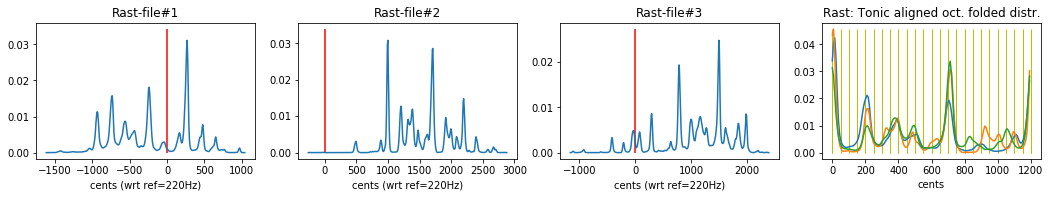

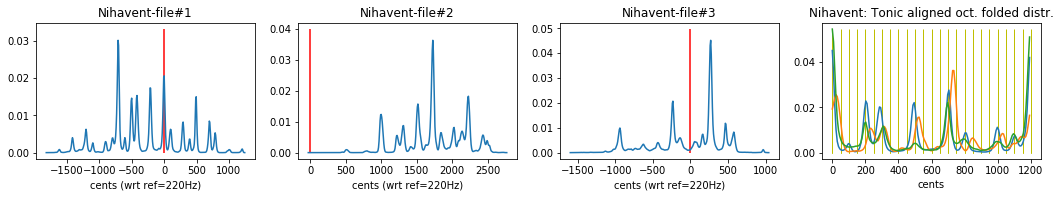

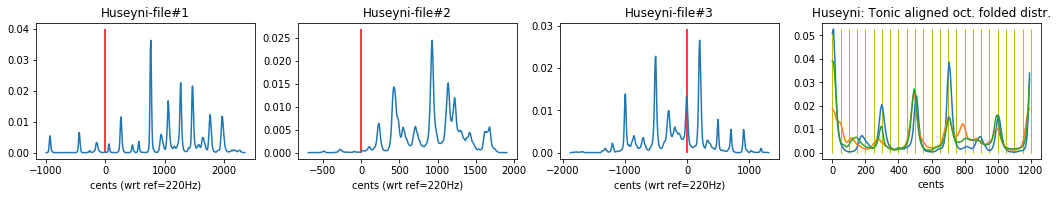

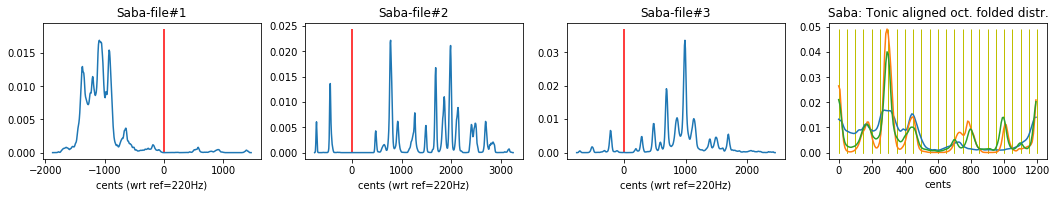

In [4]:
#Plotting pitch histograms computed with respect to REF_PITCH
makams=['Rast','Nihavent','Huseyni','Saba']
for makam in makams:
    cnt_makam=0
    plt.figure(figsize=(18, 2.5))
    for dbaFile in collectionFiles:
        if(dbaFile['makam']==makam and cnt_makam<numFiles2DownloadPerMakam):
            musicbrainzid=dbaFile['mbid'].split('http://musicbrainz.org/recording/')[-1]
            
            #Read and plot histogram with reference=REF_PITCH
            histFile=dataDir+makam+'/'+musicbrainzid+'.pitch_hist.json'
            with open(histFile) as json_data:
                hist = json.load(json_data)
            plt.subplot(1,numFiles2DownloadPerMakam+1, cnt_makam+1)
            plt.plot(hist['bins'],hist['vals'])
            plt.vlines([0], 0, np.max(hist['vals'])*1.1, color='r')
            plt.title(makam+'-file#'+str(cnt_makam+1))
            plt.xlabel('cents (wrt ref='+str(REF_PITCH)+'Hz)')
            
            #Read, octave fold the histogram with reference=tonic and plot
            with open(histFile.replace('.pitch_hist.json','.pitch_hist_wrtTonic.json')) as json_data:
                histwrtTonic = json.load(json_data)
            octaveFoldedHistBins=np.arange(0,CENTS_IN_OCTAVE,pd_params['step_size'])
            octaveFoldedHist=np.zeros_like(octaveFoldedHistBins)
            for k in range(len(histwrtTonic['bins'])):
                histBinFolded=np.mod(histwrtTonic['bins'][k],CENTS_IN_OCTAVE)
                octaveFoldedHist[int(histBinFolded/pd_params['step_size'])]+=histwrtTonic['vals'][k]
    
            plt.subplot(1,numFiles2DownloadPerMakam+1, numFiles2DownloadPerMakam+1)
            markers=np.arange(0,1250,50)
            plt.vlines(markers, 0, max(octaveFoldedHist), color='y',lw=1)
            plt.plot(octaveFoldedHistBins,octaveFoldedHist)
            plt.title(makam+': Tonic aligned oct. folded distr.')
            plt.xlabel('cents')
            
            cnt_makam+=1